# Structured Output with Julia Set Example

This example shows how to describe 'structured' output data for a `Runner`, that is, output data can have its own internal dimensions.

Let's start by defining the Julia set equation with 3 extra modifications (``p``, ``A`` and ``phi``) we want to explore:

In [1]:
%config InlineBackend.figure_formats = ['svg']

from xyzpy import *
import numba as nb
import numpy as np
from cmath import exp, pi


@nb.vectorize(nopython=True)
def _mandel(z0, p, A, phi, limit):
    z = z0
    while abs(z) < 2:
        limit -= 1
        z = z**p + A * exp(1.0j * phi)
        if limit<0:
            return 0
    return limit


def mandel(z0, p=2, A=0.7, phi=1.885, limit=100):
    m = _mandel(z0, p, A, phi, limit)
    return m, np.std(m)

Since it is explicitly vectorized, ``mandel`` takes an array of complex numbers ``z0``, and returns
how many iterations, ``m``, each value takes to diverge (or not). Let's pretend we are also interested in the standard deviation of the results so we return that as well.

Let's set up some constants including the array of complex numbers we want to supply:

In [2]:
res = 256
L = 150
re_lims, im_lims = (0.2, 0.4), (-0.4, -0.6)
r = np.linspace(*re_lims, res)
i = np.linspace(*im_lims, res)
zs = r.reshape(-1, 1) + 1.0j * i.reshape(1, -1)  # turn into grid

Now we can describe the function with a `Runner`:

In [3]:
runner = Runner(
    mandel,                         # The function
    var_names=['m', 'm_sdev'],      # The names of its output variables
    var_dims={'m': ['re', 'im']},   # The name of the internal dimensions of 'm'
    var_coords={'re': r, 'im': i},  # the coordinates of those dimensions
    constants={'limit': L},         # supply L as a constant
    resources={'z0': zs},           # supply z0 as a constant, but don't record it
)

Now let's define the parameter space we are interested in:

In [4]:
combos = {
    'p': np.linspace(1.9, 2.1, 3),
    'A': np.linspace(0.7, 0.8, 5),
    'phi': [1.85, 1.88, 1.91, 1.94, 1.97, 2.0],
}

We will thus get 5 dimensions in total: the 3 parameters in ``combos``, and the two internal dimensions ``re`` and ``im``.

Since each run might be quite slow, let's also parallelize over the runs:

In [5]:
runner.run_combos(combos, parallel=True)

  0%|          | 0/90 [00:00<?, ?it/s]

100%|##########| 90/90 [00:26<00:00,  3.42it/s]


<xarray.Dataset>
Dimensions:  (p: 3, A: 5, phi: 6, re: 256, im: 256)
Coordinates:
  * p        (p) float64 1.9 2.0 2.1
  * A        (A) float64 0.7 0.725 0.75 0.775 0.8
  * phi      (phi) float64 1.85 1.88 1.91 1.94 1.97 2.0
  * re       (re) float64 0.2 0.2008 0.2016 0.2024 ... 0.3976 0.3984 0.3992 0.4
  * im       (im) float64 -0.4 -0.4008 -0.4016 -0.4024 ... -0.5984 -0.5992 -0.6
Data variables:
    m        (p, A, phi, re, im) int64 0 0 0 0 0 0 0 ... 138 117 118 118 120 120
    m_sdev   (p, A, phi) float64 55.42 54.35 50.1 45.92 ... 9.138 8.667 10.83
Attributes:
    limit:    150

Now let's plot the main variable 'm'. Since we can only plot 4 dimensions at once we have to select a value for one dimension first:

In [6]:
ds = runner.last_ds.sel(p=2.0)
fig, axs = ds.xyz.plot(
    x='re',
    y='im',
    z='m',
    col='phi',
    row='A',
    palette='inferno',
)

We output multiple variables so we can also plot the quantity ``m_sdev``:

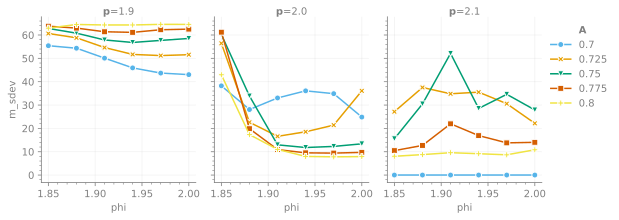

In [7]:
fig, axs = runner.last_ds.xyz.plot(
    x='phi',
    y='m_sdev',
    color='A',
    marker='A',
    col='p',
)